In [1]:
import numpy as np
import pandas as pd

# Scikit-learn Kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import chi2, SelectKBest

# NLTK Kütüphaneleri
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer

# SpaCy Kütüphanesi
import spacy

In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.7 MB/s eta 0:00:00


In [3]:
import os

# /kaggle/input altında hangi dosyalar var, listeleyelim
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


dataset oluşturma

In [4]:
# Read the dataset with name "Emotion_classify_Data.csv" and store it in a variable df
columns = ['id','uygulama','duygu_durumu','metin']
df_train= pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", names=columns)
df_validation = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", names=columns)

In [5]:
df_train.head(5)

,id,uygulama,duygu_durumu,metin
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            74682 non-null  int64 
 1   uygulama      74682 non-null  object
 2   duygu_durumu  74682 non-null  object
 3   metin         73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
# Check the distribution of Emotion
df_train['duygu_durumu'].value_counts()

duygu_durumu
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [8]:
#örnek gözlemler
for i in range(100):
    if i%25==0:
        print(f"{i+1}: {df_train['metin'][i]} -> {df_train['duygu_durumu'][i]}")

1: im getting on borderlands and i will murder you all , -> Positive
26: The biggest disappointment of my life came a year ago. -> Negative
51: Guilty of sobriety! A bit of a borderline. I was called to work early tomorrow, so I can't catch up. -> Neutral
76: imma probably play live borderlands tps in a bit. that'll be fun -> Positive


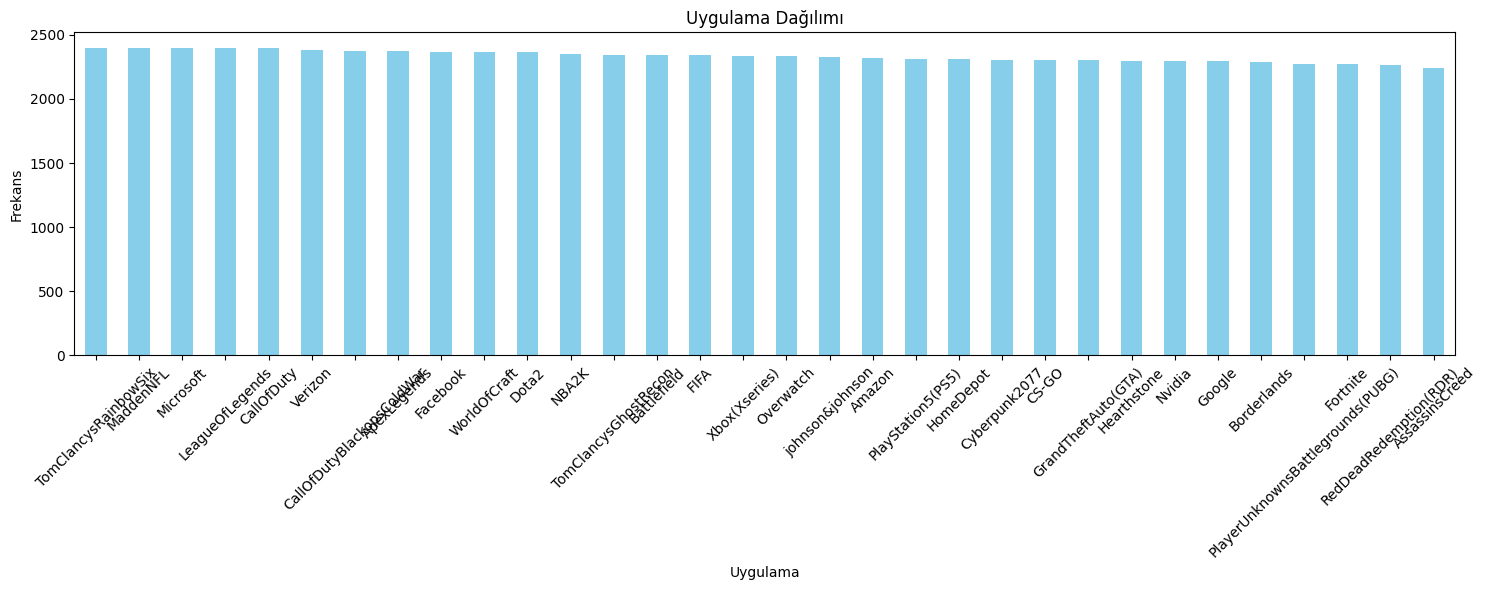

In [9]:
import matplotlib.pyplot as plt

# Uygulama sayımlarını al
uygulama_sayim = df_train['uygulama'].value_counts()

# Grafik çizimi
plt.figure(figsize=(15, 6))
uygulama_sayim.plot(kind='bar', color='skyblue')
plt.title('Uygulama Dağılımı')
plt.xlabel('Uygulama')
plt.ylabel('Frekans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
#id nasıl bir değişken diye kontrol ettiğimizde daha çok bireye veya grupa ait olduğunu gözlemledik
df_train['id'].nunique()

12447

PREPROCESSİNG İŞLEMLERİ

In [11]:
# NLTK stopwords ve tokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Küçük Harfe Dönüştürme (Lowercasing):“Good” ve “good” gibi aynı kelimenin farklı halleri tekilleştirilir.

In [12]:
# Metni küçük harfe dönüştürme işlemi
df_train['metin'] = df_train['metin'].str.lower()
df_validation['metin'] = df_validation['metin'].str.lower()


print(df_train['metin'].head(3))

0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
2    im getting on borderlands and i will kill you ...
Name: metin, dtype: object


Sayıların Kaldırılması:genellikle duygu içermez; bu yüzden çıkarılır.

In [13]:
import re

# Sayıları kaldırma işlemi
df_train['metin'] = df_train['metin'].apply(lambda s: re.sub(r'\d+', '', str(s)))
df_validation['metin'] = df_validation['metin'].apply(lambda s: re.sub(r'\d+', '', str(s)))


print(df_train['metin'].head(3))

0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
2    im getting on borderlands and i will kill you ...
Name: metin, dtype: object


noktalama işaretlerini kaldırma

In [14]:
df_train['metin'] = df_train['metin'].str.replace('[^\w\s]', '')
df_validation['metin'] = df_validation['metin'].str.replace('[^\w\s]', '')


print(df_train['metin'].head(3))

0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
2    im getting on borderlands and i will kill you ...
Name: metin, dtype: object


Stopwords Kaldırma

In [15]:
# 3. Stopwords listesinden negation'ları çıkar
stop_words = set(stopwords.words('english')) 

# 4. Metin üzerinde kelime bazlı stopword temizliği
df_train['metin'] = df_train['metin'].apply(
    lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
)
df_validation['metin'] = df_validation['metin'].apply(
    lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
)

Tokenizasyon:Metin, kelime veya sembol bazlı parçalara ayrılır (kelimelere bölme işlemidir).

In [16]:
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 2. Tokenizasyon (kısaltmalar açıldıktan sonra yapılmalı!)
df_train['tokens'] = df_train['metin'].apply(word_tokenize)
df_validation['tokens'] = df_validation['metin'].apply(word_tokenize)

Lemmatization

In [17]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Sadece kelimeyi köküne indirger
df_train['lemmas_simple'] = df_train['tokens'].apply(
    lambda toks: [lemmatizer.lemmatize(w) for w in toks]
)
df_validation['lemmas_simple'] = df_validation['tokens'].apply(
    lambda toks: [lemmatizer.lemmatize(w) for w in toks]
)

MLP KISMI TF -IDF ÜZERİNDEN

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.89      0.85      0.87      2592
    Negative       0.85      0.92      0.88      4519
     Neutral       0.91      0.86      0.88      3596
    Positive       0.90      0.88      0.89      4230

    accuracy                           0.88     14937
   macro avg       0.88      0.88      0.88     14937
weighted avg       0.88      0.88      0.88     14937



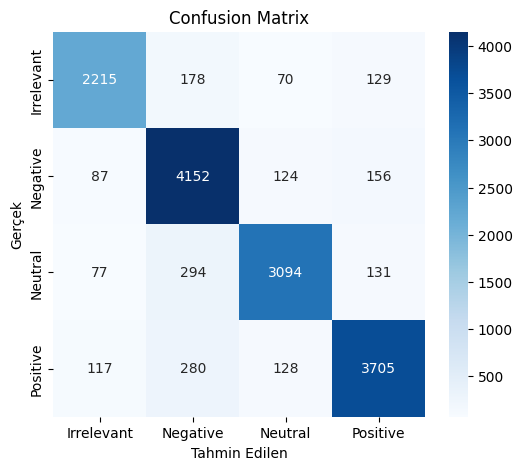

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. X ve y tanımla
x = df_train['tokens'].apply(lambda tokens: ' '.join(tokens))  # Listeyi string'e çevir
y = df_train['duygu_durumu']

# 2. TF-IDF vektörleştirme
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(x)

# 3. Eğitim ve test verilerine ayır
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# 4. MLP modelini tanımla ve eğit
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# 5. Tahmin yap
y_pred = mlp.predict(X_test)

# 6. Confusion matrix ve classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("Classification Report:\n", cr)

# 7. Confusion Matrix Görselleştirme
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mlp.classes_, yticklabels=mlp.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()